<a href="https://colab.research.google.com/github/Utharakm/IMS24255_KARATECLUB_/blob/main/KarateClub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting Recursive Bisection on 34 nodes...
Iteration 1: Splitting community [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]...
Iteration 2: Splitting community [8, 9, 14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]...
Iteration 3: Splitting community [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 16, 17, 19, 21]...
Iteration 4: Splitting community [8, 9, 30]...

Final Communities (5):
Group 1: [14, 15, 18, 20, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33]
Group 2: [0, 1, 2, 3, 7, 11, 12, 13, 17, 19, 21]
Group 3: [4, 5, 6, 10, 16]
Group 4: [8, 30]
Group 5: [9]

Generating Network Visualizations...


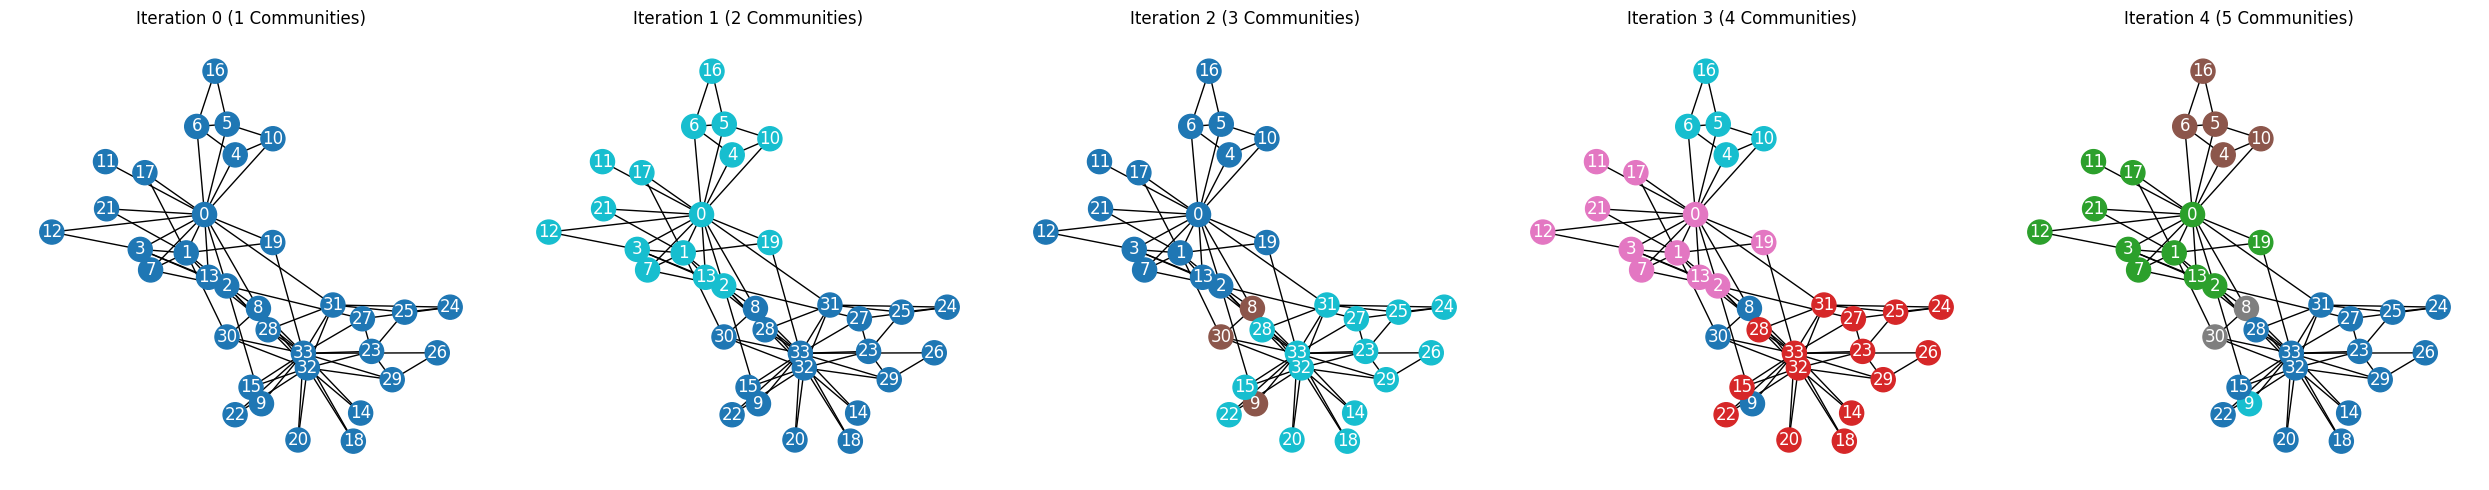

Generating Metric Evolution Plots...


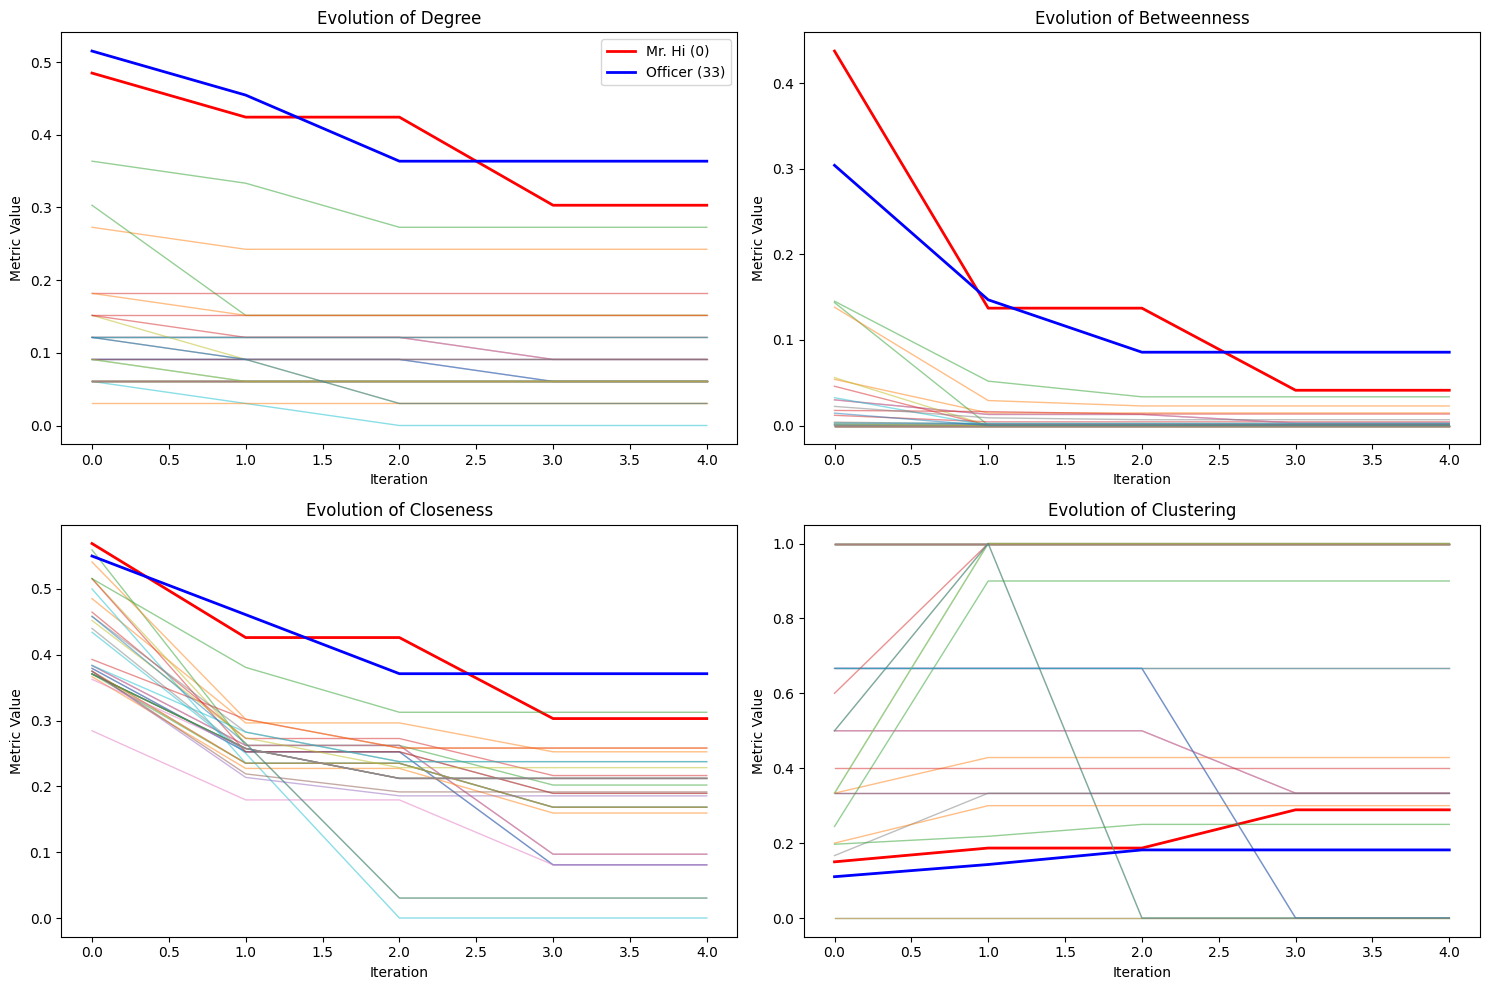

--------------------------------------------------
DISCUSSION:
As the recursion progresses, the algorithm cuts the graph into smaller, tighter communities.
The metric evolution plots show how 'centrality' is redefined as the context narrows.
Note how Mr. Hi (0) and the Officer (33) often maintain high local centrality within their
respective clusters, acting as hubs for their factions.
--------------------------------------------------


In [1]:
# ==========================================
# DSC212: Graph Theory Module
# Modularity on the Karate Club Graph
# Implementation of Recursive Spectral Bipartition
# ==========================================

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from matplotlib import cm

# [cite: 9] We use basic scientific Python tools and NetworkX
# [cite: 10] The dataset is the Karate Club Graph

def get_modularity_matrix(G):
    """
    Computes the global Modularity Matrix B.
    Formula: B = A - (k * k.T) / (2m)
     B = A - kk^T / 2m
    """
    # Get Adjacency Matrix A
    A = nx.to_numpy_array(G)

    # Get degree vector k (sum of rows of A)
    k = A.sum(axis=1).reshape(-1, 1)

    # Total edges m (sum of degrees / 2)
    m = k.sum() / 2

    # Compute expected edges (k * k.T) / 2m
    # [cite: 61] encodesthe expected number of edges under null model
    expected = np.dot(k, k.T) / (2 * m)

    # Compute Modularity Matrix B
    B = A - expected
    return B

def get_metrics(G, partition):
    """
    Computes centrality and cohesion measures for every node.
    To show 'evolution', we compute these on the graph structure
    implied by the current communities (treating communities as disconnected).
    [cite: 165] Compute standard centrality and cohesion measures.
    """
    # Create a temporary graph respecting the current partition
    # We keep edges only if both nodes are in the same community
    temp_G = G.copy()
    edges_to_remove = []

    # Map node to community index
    node_to_comm = {}
    for idx, comm in enumerate(partition):
        for node in comm:
            node_to_comm[node] = idx

    for u, v in temp_G.edges():
        if node_to_comm[u] != node_to_comm[v]:
            edges_to_remove.append((u, v))

    temp_G.remove_edges_from(edges_to_remove)

    # [cite: 166] Degree Centrality
    deg = nx.degree_centrality(temp_G)

    # [cite: 170] Betweenness Centrality
    bet = nx.betweenness_centrality(temp_G)

    # [cite: 175] Closeness Centrality
    clo = nx.closeness_centrality(temp_G)

    # [cite: 179] Clustering Coefficient
    clus = nx.clustering(temp_G)

    return {'degree': deg, 'betweenness': bet, 'closeness': clo, 'clustering': clus}

def recursive_spectral_partitioning(G):
    """
    Implements the recursive bisection algorithm.
    [cite: 150] Extend two-way spectral split into multi-community detection recursively.
    """

    # Initial Setup
    # [cite: 152] Start with the full node set V
    nodes = list(G.nodes())
    n = len(nodes)

    # Global Modularity Matrix
    B_global = get_modularity_matrix(G)

    # Current partition (initially one group)
    communities = [nodes]

    # To store history for visualization
    history = []

    # Store metrics history
    # Initialize with metrics of the full graph
    metric_history = [get_metrics(G, communities)]
    history.append(list(communities))

    iteration = 0
    split_occurred = True

    print(f"Starting Recursive Bisection on {n} nodes...")

    while split_occurred:
        split_occurred = False
        best_split = None
        split_index = -1

        # Iterate over current communities to find if any can be split
        for idx, comm in enumerate(communities):
            if len(comm) <= 1:
                continue

            # [cite: 123] B^(C) is the restriction of global B to rows/cols of C
            # Map actual node IDs to matrix indices
            comm_indices = comm # Since node IDs are 0-33, they match indices directly
            B_sub = B_global[np.ix_(comm_indices, comm_indices)]

            # [cite: 126] Compute leading eigenpair
            eigvals, eigvecs = la.eigh(B_sub)

            # eigh returns ascending, so largest is at index -1
            lambda_1 = eigvals[-1]
            u_1 = eigvecs[:, -1]

            # [cite: 127] If lambda > 0, splitting increases modularity
            # [cite: 155] If lambda <= 0, stop (group indivisible)
            if lambda_1 > 1e-5: # Using small epsilon for float stability

                # [cite: 156] Split nodes into C+ and C- by sign of u1
                # We found a candidate split.
                # In a greedy approach, we could take the split with max lambda,
                # or just split the first one found. Here we split the first valid one found per pass.

                c_plus = []
                c_minus = []

                for i, val in enumerate(u_1):
                    node_id = comm[i]
                    if val > 0:
                        c_plus.append(node_id)
                    else:
                        c_minus.append(node_id)

                # Only accept if we actually split into non-empty sets
                if len(c_plus) > 0 and len(c_minus) > 0:
                    best_split = (c_plus, c_minus)
                    split_index = idx
                    split_occurred = True
                    break

        # Apply the split
        if split_occurred:
            iteration += 1
            print(f"Iteration {iteration}: Splitting community {communities[split_index]}...")

            # Remove old community, add two new ones
            # [cite: 157] Recurse on C+ and C- separately
            del communities[split_index]
            communities.append(best_split[0])
            communities.append(best_split[1])

            # Record history
            history.append(list(communities))
            metric_history.append(get_metrics(G, communities))

    return communities, history, metric_history

# ==========================================
# Main Execution and Visualization
# ==========================================

# 1. Load Data
# [cite: 15] The Karate Club graph
G = nx.karate_club_graph()

# 2. Run Algorithm
# [cite: 191] Implement recursive spectral modularity partitioning
final_communities, history, metric_history = recursive_spectral_partitioning(G)

print(f"\nFinal Communities ({len(final_communities)}):")
for i, c in enumerate(final_communities):
    print(f"Group {i+1}: {sorted(c)}")

# 3. Visualization of Splits
#  Draw graph using a fixed spring layout
pos = nx.spring_layout(G, seed=42)

num_iterations = len(history)
fig, axes = plt.subplots(1, num_iterations, figsize=(5 * num_iterations, 5))
if num_iterations == 1: axes = [axes]

print("\nGenerating Network Visualizations...")

for i, (ax, partition) in enumerate(zip(axes, history)):
    # [cite: 162] Assign unique color to each community
    # Create a color map
    node_colors = []
    for node in G.nodes():
        for comm_idx, comm in enumerate(partition):
            if node in comm:
                node_colors.append(comm_idx)
                break

    ax.set_title(f"Iteration {i} ({len(partition)} Communities)")
    # [cite: 163] Label nodes by ID
    nx.draw_networkx(G, pos, ax=ax, node_color=node_colors,
                     with_labels=True, cmap=plt.cm.tab10,
                     node_size=300, font_color='white')
    ax.axis('off')

plt.tight_layout()
plt.show()

# 4. Visualization of Metric Evolution
# [cite: 198] Plot evolution of each metric across iterations for every node
metrics_names = ['degree', 'betweenness', 'closeness', 'clustering']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

print("Generating Metric Evolution Plots...")

iterations_range = range(len(history))

for i, metric_name in enumerate(metrics_names):
    ax = axes[i]
    ax.set_title(f"Evolution of {metric_name.capitalize()}")
    ax.set_xlabel("Iteration")
    ax.set_ylabel("Metric Value")

    # Plot a line for each node
    for node in G.nodes():
        values = [m[metric_name][node] for m in metric_history]
        ax.plot(iterations_range, values, alpha=0.5, linewidth=1)

        # Highlight key nodes (Mr. Hi: 0, Officer: 33)
        if node == 0:
            ax.plot(iterations_range, values, color='red', linewidth=2, label='Mr. Hi (0)')
        elif node == 33:
            ax.plot(iterations_range, values, color='blue', linewidth=2, label='Officer (33)')

    if i == 0: # Add legend only to first plot to avoid clutter
        ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

#  Discussion
print("-" * 50)
print("DISCUSSION:")
print("As the recursion progresses, the algorithm cuts the graph into smaller, tighter communities.")
print("The metric evolution plots show how 'centrality' is redefined as the context narrows.")
print("Note how Mr. Hi (0) and the Officer (33) often maintain high local centrality within their")
print("respective clusters, acting as hubs for their factions.")
print("-" * 50)